## Import libraries


In [1]:
import zipfile
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read training data

In [2]:
def load_fashion_mnist(file_path):
    with zipfile.ZipFile(file_path, 'r') as z:
        z.extractall()
    # Charger les données
    data = pd.read_csv("fashion-mnist_train.csv")
    X = data.iloc[:, 1:].values  # Les pixels
    y = data.iloc[:, 0].values   # Les labels
    return X, y

## Siamese Network


* Siamese Network: Encodes data in a reduced space to calculate similarity.

* Attention mechanism: Identifies relevant dimensions in embeddings to improve accuracy.

* Dynamic weighting: A linear layer learns to combine different types of distances. (Cosine, Euclidean and product)


In [3]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim=784, embedding_dim=64):
        super(SiameseNetwork, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Dropout(0.5),

            nn.Linear(128, embedding_dim),
            nn.ReLU()
        )


        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.Tanh(),
            nn.Linear(embedding_dim, 1),
            nn.Softmax(dim=1)
        )

        # Fusion of distances with dynamic weights
        self.distance_fusion = nn.Sequential(
            nn.Linear(3, 1),  # Combines cosine, euclidean, and product
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.embedding(x)

    def similarity(self, embedding_a, embedding_b):
        # Appliquer l'attention
        # Add attention weight regularization
        attention_weights_a = torch.clamp(self.attention(embedding_a), min=0, max=1)
        attention_weights_b = torch.clamp(self.attention(embedding_b), min=0, max=1)


        # Pondérer les embeddings
        weighted_a = F.normalize(embedding_a * attention_weights_a, p=2, dim=1)
        weighted_b = F.normalize(embedding_b * attention_weights_b, p=2, dim=1)


        # Calculer les distances pondérées
        diff = torch.abs(weighted_a - weighted_b)
        cosine_sim = nn.functional.cosine_similarity(weighted_a, weighted_b)
        euclidean_dist = torch.norm(diff, dim=1)
        product = torch.sum(weighted_a * weighted_b, dim=1)

        # Combiner les distances et appliquer Sigmoid (plusieurs version, enlever commentaires de la version à tester)
        #version1: combinaison de cosine_sim, euclidean_dist et product
        distances = torch.stack([cosine_sim * 2, euclidean_dist, product], dim=1)
        #version2: cosine_sim uniquement
        #distances = torch.stack([cosine_sim, cosine_sim, cosine_sim], dim=1)
        #version3: euclidean_dist uniquement
        #distances = torch.stack([euclidean_dist, euclidean_dist, euclidean_dist], dim=1)
        fused_similarity = self.distance_fusion(distances).squeeze()
        return torch.sigmoid(fused_similarity)

## Loss function

In [4]:
# Define Triplet Loss
class TripletLoss(nn.Module):
    def __init__(self):
        super(TripletLoss, self).__init__()

    def forward(self, anchor, positive, negative, margin):
        # Calculate positive and negative distances
        pos_dist = torch.norm(anchor - positive, dim=1)
        neg_dist = torch.norm(anchor - negative, dim=1)

        # Loss calculation with dynamic margin
        loss = torch.mean(torch.clamp(pos_dist - neg_dist + margin, min=0.0))
        return loss

## Train and test functions for the Siamese Network



In [5]:
def train_siamese(model, train_loader, epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Weight decay for L2
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  #Diminuer le taux d'apprentissage tous les 10 epochs
    criterion = TripletLoss(margin=1.0)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for pair_a, pair_b, labels in train_loader:
            pair_a, pair_b, labels = pair_a.float(), pair_b.float(), labels.float()

            optimizer.zero_grad()
            embed_a = model(pair_a)
            embed_b = model(pair_b)
            similarity_scores = model.similarity(embed_a, embed_b)
            loss = criterion(embed_anchor, embed_positive, embed_negative)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

def test_siamese(model, test_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for pair_a, pair_b, labels in test_loader:
            pair_a, pair_b, labels = pair_a.float(), pair_b.float(), labels.float()
            embed_a = model(pair_a)
            embed_b = model(pair_b)
            similarity_scores = model.similarity(embed_a, embed_b)
            all_labels.extend(labels.numpy())
            all_scores.extend(similarity_scores.numpy())

    auc = roc_auc_score(all_labels, all_scores)
    print(f"Test AUC: {auc:.4f}")


## Prepare the data

In [6]:
def prepare_data(X, y):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pairs, labels = [], []
    for i in range(len(y)):
        for j in range(i+1, len(y)):
            pairs.append((X[i], X[j]))
            labels.append(1 if y[i] == y[j] else 0)
    pair_a = np.array([p[0] for p in pairs])
    pair_b = np.array([p[1] for p in pairs])
    return pair_a, pair_b, np.array(labels)

## Training of the model


As the dataset is quite large, positive and negative pairs are dynamically generated during training, which keeps the memory under control.


In [7]:
def precompute_embeddings(dataset, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for data in DataLoader(dataset, batch_size=128):  # Ajustez batch_size
            data = data.to(device).float()
            embeddings.append(model(data))
    return torch.cat(embeddings, dim=0)

In [8]:
# Dynamic generation of triplet during training

class TripletDataset(Dataset):
    def __init__(self, X, y, model, precomputed_embeddings=None, threshold=None):
        self.X = X
        self.y = y
        self.model = model
        self.precomputed_embeddings = precomputed_embeddings
        self.threshold = threshold  # Threshold pour le hard negative mining

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Anchor
        anchor = torch.tensor(self.X[idx], dtype=torch.float32)

        # Positive samples
        positive_indices = np.where(self.y == self.y[idx])[0]
        if len(positive_indices) < 2:  # Ensure at least one valid positive
            raise IndexError("No valid positive samples found.")
        positive_idx = np.random.choice(positive_indices)
        positive = torch.tensor(self.X[positive_idx], dtype=torch.float32)

        # Negative candidates
        negative_candidates = np.where(self.y != self.y[idx])[0]
        if len(negative_candidates) < 1:  # Ensure at least one valid negative
            raise IndexError("No valid negative samples found.")

        # Hard Negative Mining (using precomputed embeddings)
        if self.precomputed_embeddings is not None:
            with torch.no_grad():
                anchor_embedding = self.precomputed_embeddings[idx]
                neg_embeddings = self.precomputed_embeddings[negative_candidates]
                distances = torch.norm(anchor_embedding - neg_embeddings, dim=1)

                # Filter negatives based on the threshold
                if self.threshold is not None:
                    hard_negatives = distances[distances < self.threshold + 0.2] #Increased treshold
                    if len(hard_negatives) == 0:
                        hard_negative_idx = negative_candidates[torch.argmin(distances)]
                    else:
                        hard_negative_idx = negative_candidates[torch.argmin(hard_negatives)]
                else:
                    hard_negative_idx = negative_candidates[torch.argmin(distances)]

                hard_negative = torch.tensor(self.X[hard_negative_idx], dtype=torch.float32)
        else:
            hard_negative_idx = np.random.choice(negative_candidates)
            hard_negative = torch.tensor(self.X[hard_negative_idx], dtype=torch.float32)

        return anchor, positive, hard_negative




def train_model(model, train_loader, epochs, lr):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = TripletLoss()  # No fixed margin here
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Get the device

    # List to store loss for each epoch
    epoch_losses = []


    for epoch in range(epochs):
        epoch_loss = 0.0

        # Example: Adjust margin dynamically based on the epoch
        margin = 1.0 + (epoch / epochs) * 0.5  # Grow margin from 1.0 to 1.5

        for batch in train_loader:
            anchor, positive, negative = batch
            anchor = anchor.float().to(device) # Move to device
            positive = positive.float().to(device) # Move to device
            negative = negative.float().to(device) # Move to device

            optimizer.zero_grad()

            # Forward pass
            embed_anchor = model(anchor)
            embed_positive = model(positive)
            embed_negative = model(negative)

            # Compute triplet loss with dynamic margin
            loss = criterion(embed_anchor, embed_positive, embed_negative, margin)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Margin: {margin:.4f}, Loss: {epoch_loss:.4f}")

        # Append the epoch loss to the list
        epoch_losses.append(epoch_loss)

    # Plotting the loss
    plt.plot(range(1, epochs + 1), epoch_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


## Test du modèle


In [9]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    all_scores_pos, all_scores_neg = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Get device
    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor, positive, negative = anchor.float().to(device), positive.float().to(device), negative.float().to(device) # Move to device

            # Compute embeddings
            embed_anchor = model(anchor)
            embed_positive = model(positive)
            embed_negative = model(negative)

            # Compute similarity scores
            pos_similarity = model.similarity(embed_anchor, embed_positive)
            neg_similarity = model.similarity(embed_anchor, embed_negative)

            # Accuracy computation
            correct += torch.sum(pos_similarity > neg_similarity).item()
            total += anchor.size(0)

            # Store scores for analysis
            all_scores_pos.extend(pos_similarity.cpu().numpy())
            all_scores_neg.extend(neg_similarity.cpu().numpy())

    # Compute accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Optional: Further analysis (e.g., histograms of similarity scores)
    return all_scores_pos, all_scores_neg

Precomputing embeddings for the dataset...
Embedding computation done. Using precomputed embeddings.
Epoch 1/60, Margin: 1.0000, Loss: 1373.0120
Epoch 2/60, Margin: 1.0083, Loss: 1070.6176
Epoch 3/60, Margin: 1.0167, Loss: 981.1144
Epoch 4/60, Margin: 1.0250, Loss: 917.0038
Epoch 5/60, Margin: 1.0333, Loss: 881.1197
Epoch 6/60, Margin: 1.0417, Loss: 844.0872
Epoch 7/60, Margin: 1.0500, Loss: 814.3394
Epoch 8/60, Margin: 1.0583, Loss: 782.1633
Epoch 9/60, Margin: 1.0667, Loss: 753.3897
Epoch 10/60, Margin: 1.0750, Loss: 726.2635
Epoch 11/60, Margin: 1.0833, Loss: 700.7312
Epoch 12/60, Margin: 1.0917, Loss: 669.0665
Epoch 13/60, Margin: 1.1000, Loss: 650.0765
Epoch 14/60, Margin: 1.1083, Loss: 635.1118
Epoch 15/60, Margin: 1.1167, Loss: 621.3938
Epoch 16/60, Margin: 1.1250, Loss: 605.0766
Epoch 17/60, Margin: 1.1333, Loss: 593.6543
Epoch 18/60, Margin: 1.1417, Loss: 578.0295
Epoch 19/60, Margin: 1.1500, Loss: 560.0640
Epoch 20/60, Margin: 1.1583, Loss: 552.1579
Epoch 21/60, Margin: 1.166

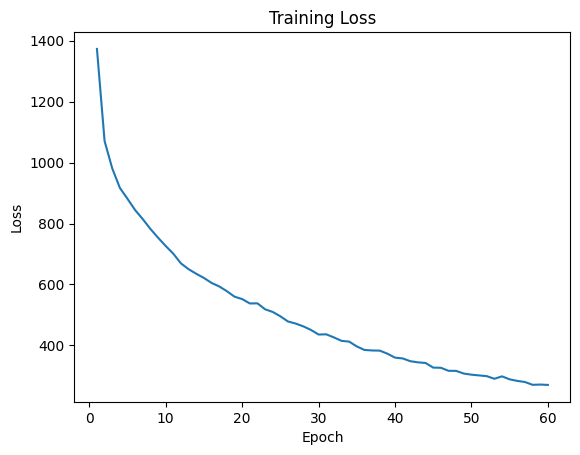

Test Accuracy: 0.9682


In [10]:
# Main
if __name__ == "__main__":
    # Load and preprocess data
    file_path = "/content/drive/My Drive/Colab Notebooks/Projet 3A/4. New measure/fashion_mnist_train.zip"
    X, y = load_fashion_mnist(file_path)

    # Normalize and flatten data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.reshape(X.shape[0], -1)  # Ensure shape is [batch_size, 784]

    # Initialize the Siamese Network
    embedding_net = SiameseNetwork(input_dim=784, embedding_dim=64)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    embedding_net.to(device)

    # Define a threshold for hard negative mining
    threshold = 0.5

    # Precompute embeddings for the dataset
    print("Precomputing embeddings for the dataset...")
    precomputed_embeddings = precompute_embeddings(X, embedding_net, device)

    # Save embeddings and pass them to the dataset
    print("Embedding computation done. Using precomputed embeddings.")

    # Prepare DataLoader with TripletDataset and precomputed embeddings
    train_dataset = TripletDataset(X, y, model=embedding_net, precomputed_embeddings=precomputed_embeddings, threshold=0.7) #augmentation du seuil du hard negative mining pour voir
    test_dataset = TripletDataset(X, y, model=embedding_net, precomputed_embeddings=precomputed_embeddings, threshold=0.5)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

    # Train the model
    train_model(embedding_net, train_loader, epochs=60, lr=0.0005)


    # Evaluate the model
    pos_scores, neg_scores = test_model(embedding_net, test_loader)

## Visualization of Embeddings


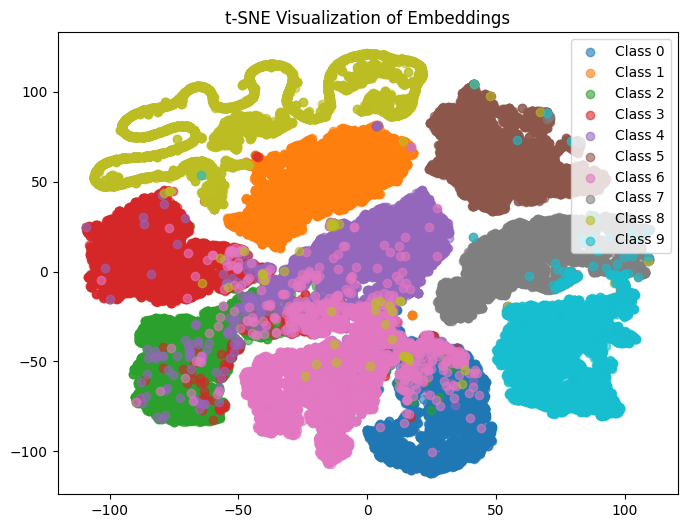

In [11]:
from sklearn.manifold import TSNE

#t-SNE visualization of embeddings

def plot_embeddings(model, X, y):
    model.eval()
    with torch.no_grad():
        embeddings = model(torch.tensor(X, dtype=torch.float32, device = "cuda"))
    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings.cpu().numpy())
    #embeddings_2d = embeddings.cpu().numpy()

    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        indices = y == label
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f"Class {label}", alpha=0.6)
    plt.title("t-SNE Visualization of Embeddings")
    plt.legend()
    plt.show()

# Call this function:
plot_embeddings(embedding_net, X, y)

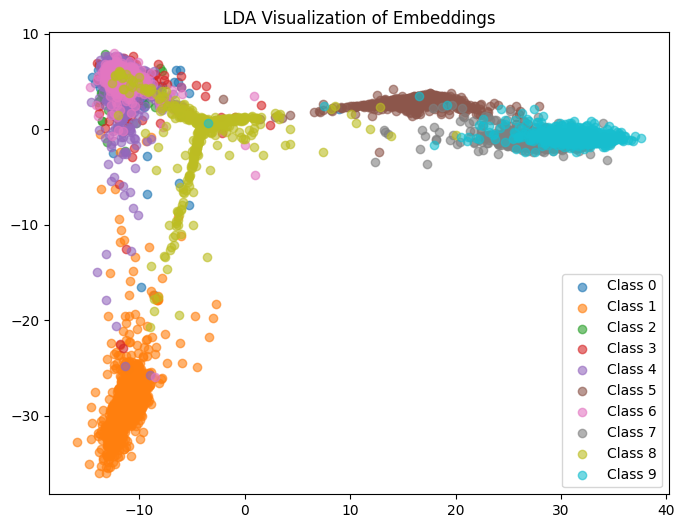

In [12]:
#LDA visualization of embeddings

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def plot_embeddings_lda(model, X, y):
    model.eval()
    with torch.no_grad():
        embeddings = model(torch.tensor(X, dtype=torch.float32, device = "cuda"))
    embeddings_2d = LinearDiscriminantAnalysis(n_components=2).fit_transform(embeddings.cpu().numpy(), y)

    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        indices = y == label
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f"Class {label}", alpha=0.6)
    plt.title("LDA Visualization of Embeddings")
    plt.legend()
    plt.show()

# Call this function:
plot_embeddings_lda(embedding_net, X, y)

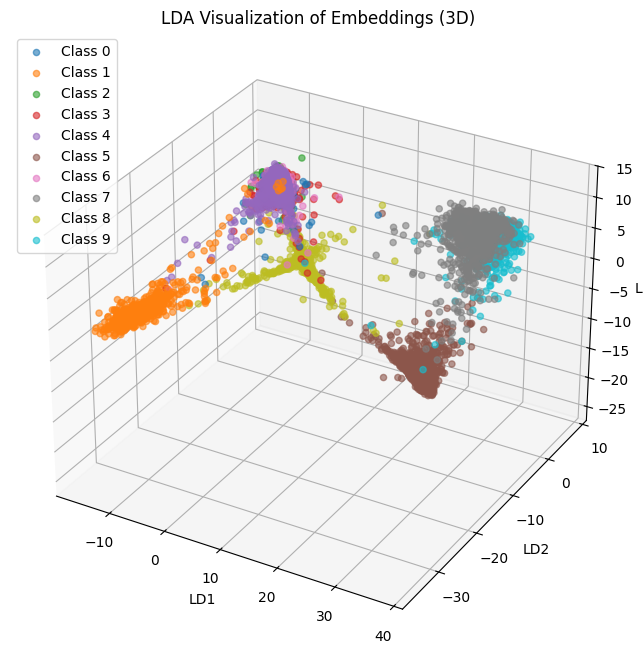

In [13]:
# LDA 3 dimensions

def plot_embeddings_lda3D(model, X, y):
    model.eval()
    with torch.no_grad():
        embeddings = model(torch.tensor(X, dtype=torch.float32, device="cuda"))
    embeddings_2d = LinearDiscriminantAnalysis(n_components=3).fit_transform(embeddings.cpu().numpy(), y)

    # 3D plotting
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for label in np.unique(y):
        indices = y == label
        ax.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], embeddings_2d[indices, 2], label=f"Class {label}", alpha=0.6)

    ax.set_title("LDA Visualization of Embeddings (3D)")
    ax.set_xlabel("LD1")
    ax.set_ylabel("LD2")
    ax.set_zlabel("LD3")
    plt.legend()
    plt.show()

# Call this function:
plot_embeddings_lda3D(embedding_net, X, y)

## Histogram Visualization with threshold

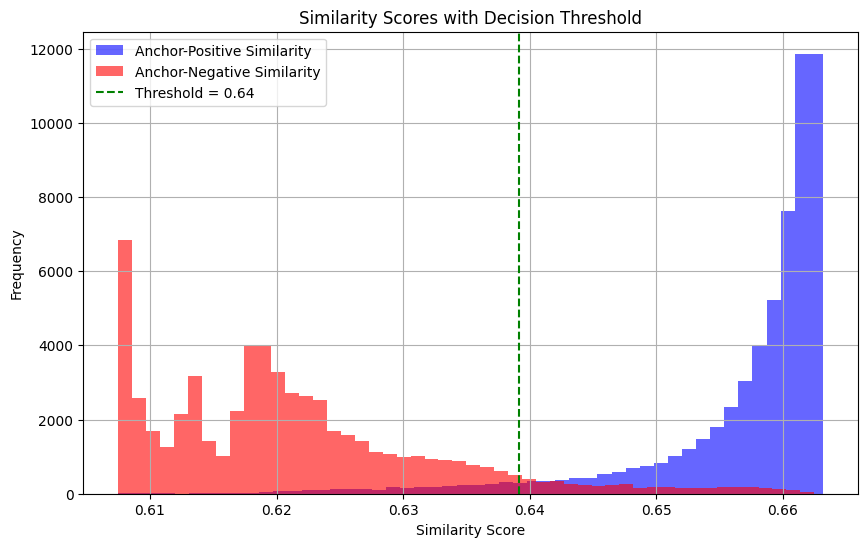

In [14]:
def analyze_threshold(pos_scores, neg_scores):
    all_scores = np.concatenate([pos_scores, neg_scores])
    threshold = np.mean(all_scores)  # Example threshold (mean of all scores)

    plt.figure(figsize=(10, 6))
    plt.hist(pos_scores, bins=50, alpha=0.6, label='Anchor-Positive Similarity', color='blue')
    plt.hist(neg_scores, bins=50, alpha=0.6, label='Anchor-Negative Similarity', color='red')

    plt.axvline(x=threshold, color='green', linestyle='--', label=f'Threshold = {threshold:.2f}')
    plt.title('Similarity Scores with Decision Threshold')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
analyze_threshold(pos_scores, neg_scores)

## Density plot

<ipython-input-14-b233faa15939>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_scores, shade=True, label='Anchor-Positive Similarity', color='blue')
<ipython-input-14-b233faa15939>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_scores, shade=True, label='Anchor-Negative Similarity', color='red')


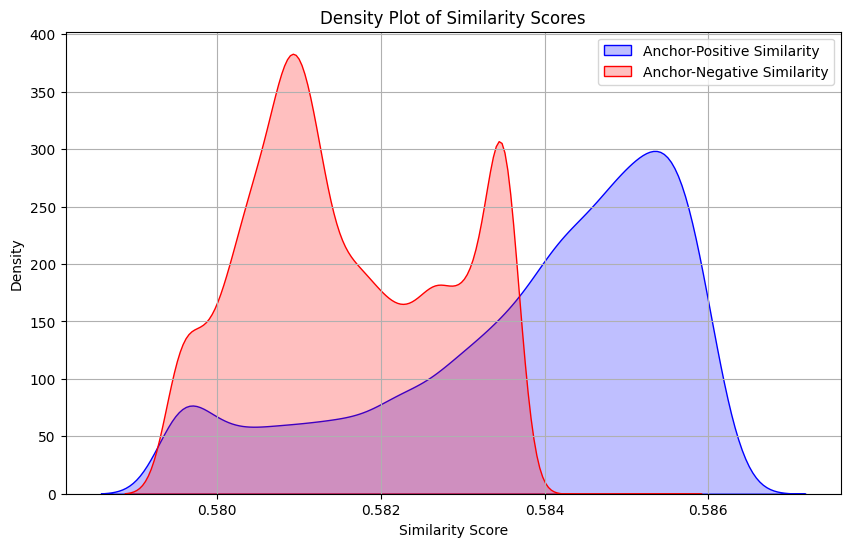

In [ ]:
def plot_density(pos_scores, neg_scores):
    plt.figure(figsize=(10, 6))

    # Density for positive scores
    sns.kdeplot(pos_scores, shade=True, label='Anchor-Positive Similarity', color='blue')

    # Density for negative scores
    sns.kdeplot(neg_scores, shade=True, label='Anchor-Negative Similarity', color='red')

    plt.title('Density Plot of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_density(pos_scores, neg_scores)

## Box plot

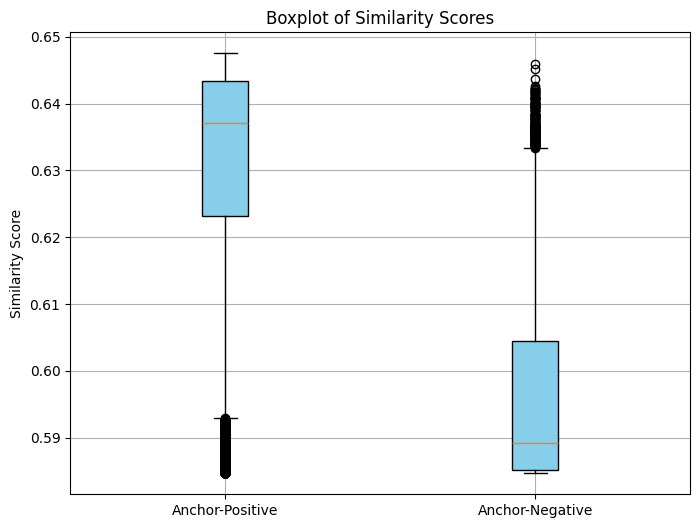

In [ ]:
def plot_boxplot(pos_scores, neg_scores):
    plt.figure(figsize=(8, 6))

    # Combine scores into a single dataset
    data = [pos_scores, neg_scores]
    labels = ['Anchor-Positive', 'Anchor-Negative']

    # Plot boxplot
    plt.boxplot(data, labels=labels, patch_artist=True, boxprops=dict(facecolor="skyblue"))

    plt.title('Boxplot of Similarity Scores')
    plt.ylabel('Similarity Score')
    plt.grid(True)
    plt.show()

# Call the function
plot_boxplot(pos_scores, neg_scores)

## Scatter plot

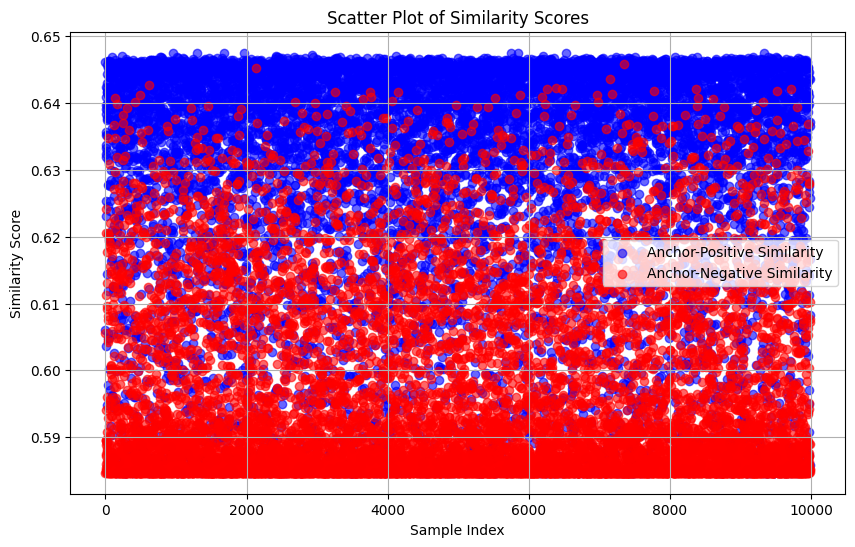

In [ ]:
def plot_scatter(pos_scores, neg_scores):
    plt.figure(figsize=(10, 6))

    # Indices for x-axis
    indices = list(range(len(pos_scores)))

    # Scatter plot
    plt.scatter(indices, pos_scores, label='Anchor-Positive Similarity', color='blue', alpha=0.6)
    plt.scatter(indices, neg_scores, label='Anchor-Negative Similarity', color='red', alpha=0.6)

    plt.title('Scatter Plot of Similarity Scores')
    plt.xlabel('Sample Index')
    plt.ylabel('Similarity Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_scatter(pos_scores, neg_scores)

## Test of the model

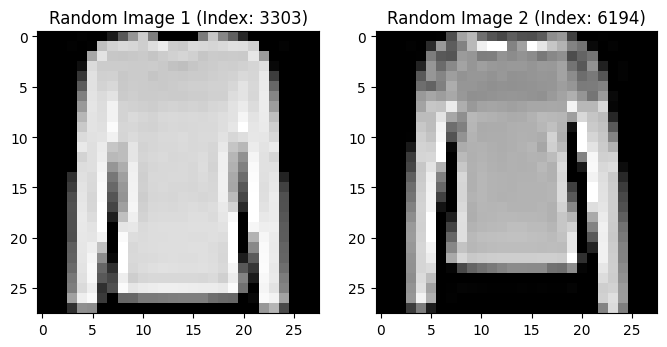

Similarity Score between the two random images: 0.66003


In [19]:
#Take two random images from mnist_test.csv to test the trained model
X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet 3A/4. New measure/fashion-mnist_test.csv')
X_test = X_test.values

# Get two random indices
random_indices = random.sample(range(len(X_test)), 2)

# Get the images at those indices, EXCLUDING the first column (likely the label)
image1 = X_test[random_indices[0], 1:]  # Select columns from index 1 onwards
image2 = X_test[random_indices[1], 1:]  # Select columns from index 1 onwards

# Reshape images to 28x28 for display
image1_display = image1.reshape(28, 28)
image2_display = image2.reshape(28, 28)

# Display images using matplotlib
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image1_display, cmap='gray')
plt.title(f"Random Image 1 (Index: {random_indices[0]})")

plt.subplot(1, 2, 2)
plt.imshow(image2_display, cmap='gray')
plt.title(f"Random Image 2 (Index: {random_indices[1]})")

plt.show()

# Preprocess images (scaling, flattening)
image1_processed = scaler.transform(image1.reshape(1, -1)).reshape(1, -1)
image2_processed = scaler.transform(image2.reshape(1, -1)).reshape(1, -1)

# Convert to PyTorch tensors and move to device
image1_tensor = torch.tensor(image1_processed, dtype=torch.float32).to(device)
image2_tensor = torch.tensor(image2_processed, dtype=torch.float32).to(device)

# Calculate similarity
with torch.no_grad():
    embedding1 = embedding_net(image1_tensor)
    embedding2 = embedding_net(image2_tensor)
    similarity_score = embedding_net.similarity(embedding1, embedding2).item()

print(f"Similarity Score between the two random images: {similarity_score:.5f}")